# Introduction to Statistical Learning

This is the code from the short course by Andrés M. Villegas entitled *Introduction to Statistical Learning*.

# Load Packages

Here are a few packages that need to be installed.

In [1]:
#--------------------------------------------------------------
# Packages
#--------------------------------------------------------------

# List of packages
packages <- c("tidyverse",    #Data cleaning and plotting
              "glmnet",       #Lasso, ridge
              "rpart",        #Fitting a tree
              "rpart.plot",   #Plotting a tree
              "randomForest", #Random forest
              "gbm",          #Boosting
              "pROC"          #ROC and model evaluation
)

# Function to install and load packages
install_and_load_packages <- function(packages) {
  for(package in packages) {
    # Check if the package is installed
    if (!require(package, character.only = TRUE)) {
      # Install the package if it's not already installed
      install.packages(package, repos = "http://cran.us.r-project.org")
      # Load the package
      library(package, character.only = TRUE)
    }
  }
}

# Use the function to install and load packages
install_and_load_packages(packages)

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: glmnet

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘glmnet’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked fro

#  Data Preparation and Exploration

In [2]:
#--------------------------------------------------------------
# Read and prepare the data
#--------------------------------------------------------------
library(tidyverse)

vicData <- read_csv(file = "https://raw.githubusercontent.com/OpenActTextDev/ActuarialRegression/refs/heads/main/CSVData/VicRoadFatalData.csv")

str(vicData) # check the data



Rows: 200000 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (21): DRIVER_ID, SEX, Age Group, LICENCE_STATE, HELMET_BELT_WORN, VEHIC...
dbl   (7): AGE, VEHICLE_YEAR_MANUF, OWNER_POSTCODE, TOTAL_NO_OCCUPANTS, SPEE...
lgl   (1): fatal
time  (1): ACCIDENTTIME

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


spc_tbl_ [200,000 × 30] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ DRIVER_ID         : chr [1:200000] "T20060000010-B" "T20060000018-A" "T20060000018-B" "T20060000023-A" ...
 $ SEX               : chr [1:200000] "F" "M" "F" "M" ...
 $ AGE               : num [1:200000] 62 30 20 43 84 51 50 28 18 61 ...
 $ Age Group         : chr [1:200000] "60-64" "30-39" "18-21" "40-49" ...
 $ LICENCE_STATE     : chr [1:200000] "Victoria" "Victoria" "Victoria" "Victoria" ...
 $ HELMET_BELT_WORN  : chr [1:200000] "Seatbelt worn" "Seatbelt worn" "Seatbelt worn" "Seatbelt worn" ...
 $ VEHICLE_ID        : chr [1:200000] "T20060000010-B" "T20060000018-A" "T20060000018-B" "T20060000023-A" ...
 $ VEHICLE_YEAR_MANUF: num [1:200000] 2003 1998 1991 1997 1986 ...
 $ VEHICLE_BODY_STYLE: chr [1:200000] "COUPE" "DC UTE" "SEDAN" "SEDAN" ...
 $ VEHICLE_MAKE      : chr [1:200000] "Other" "TOYOTA" "SUBARU" "FORD" ...
 $ VEHICLE_TYPE      : chr [1:200000] "Car" "Utility" "Car" "Car" ...
 $ FUEL_TYPE         : chr [1:200

In [3]:
#Remove variables
vicDataPre <-  vicData %>%
  select(-DRIVER_ID,
         -VEHICLE_ID,
         -OWNER_POSTCODE, #It has too many levels
         -ACCIDENT_NO,
         - DAY_OF_WEEK,
         -fatal,
         -accident_cnt)

#Create new variables based on data and time

vicDataPre <- vicDataPre %>%
  mutate(hour = (hour(ACCIDENTTIME)),
         ACCIDENTDATE = as.Date(ACCIDENTDATE, format = "%d/%m/%Y"),
         month = (month(ACCIDENTDATE)),
         year = (year(ACCIDENTDATE)),
         hour_fac = factor(hour),       #Use factors for glm but continuous for
         month_fac = factor(month),     #for tree-based methods
         year_fac = factor(year)) %>%
  rename(AGE_GROUP = `Age Group`) %>%   #Rename variable to remove space which cause problems for some methods
  select(-ACCIDENTTIME, -ACCIDENTDATE)

#Convert character variables to factor (necessary for some methods)
vicDataPre[] <- lapply(vicDataPre, function(x) if(is.character(x)) as.factor(x) else x)


In [4]:
#--------------------------------------------------------------
# Split the data into training and testing
#--------------------------------------------------------------

n <- nrow(vicDataPre)
set.seed(123)

indexTrain <- sample(1:n, round(n*0.8)) #Do 80/20 split

vicDataTrain <- vicDataPre[indexTrain, ]
vicDataTest <- vicDataPre[-indexTrain, ]


Next, some exploratory plots

`summarise()` has grouped output by 'hour_fac'. You can override using the
`.groups` argument.


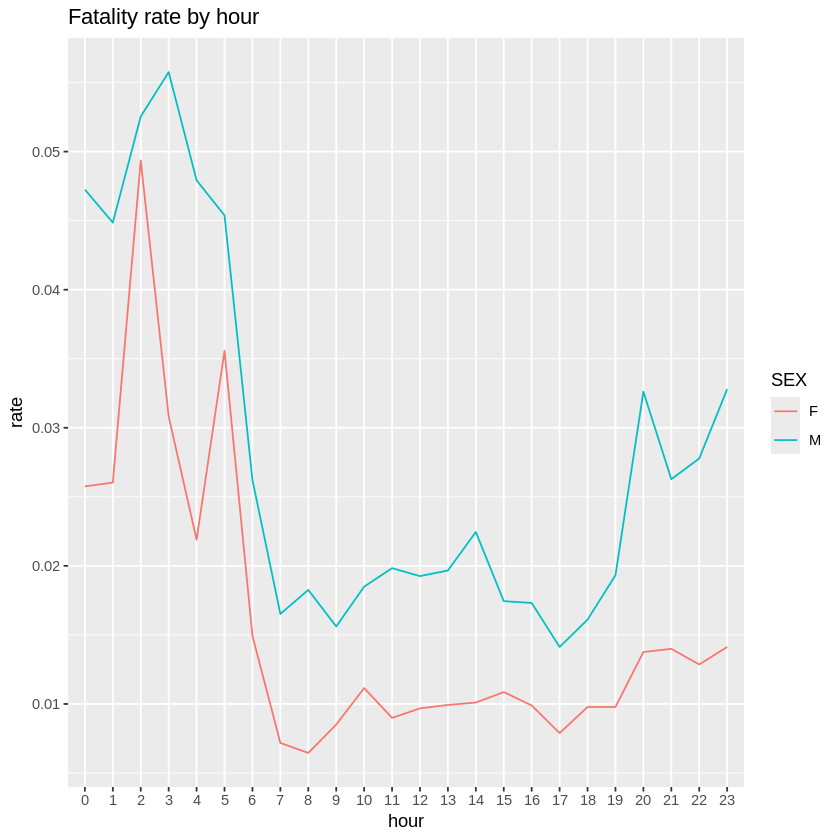

In [5]:
#--------------------------------------------------------------
# Exploratory plots
#--------------------------------------------------------------

#Plot by hour
fat_hour <- vicDataPre %>%
  group_by(hour_fac, SEX) %>%
  summarise(rate = mean(fatal_cnt))

fat_hour_plot <- ggplot(fat_hour %>% filter(SEX != "U")) +
  geom_line(aes(x = hour_fac, y = rate, group = SEX, colour = SEX)) +
  labs(title = "Fatality rate by hour", x = "hour")

print(fat_hour_plot)

#  GLM and Lasso

## GLM

In [6]:
#--------------------------------------------------------------
# GLM
#--------------------------------------------------------------

#Simple glm using only few variables

glmSimple <- glm(fatal_cnt ~ SEX +  AGE_GROUP + HELMET_BELT_WORN +
                   Weekday + hour_fac, family = binomial(),
                 data = vicDataTrain)

summary(glmSimple)


Call:
glm(formula = fatal_cnt ~ SEX + AGE_GROUP + HELMET_BELT_WORN + 
    Weekday + hour_fac, family = binomial(), data = vicDataTrain)

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -3.4885057  0.2509455 -13.901  < 2e-16 ***
SEXM                               0.6705898  0.0455106  14.735  < 2e-16 ***
SEXU                              -0.3836572  0.7115944  -0.539 0.589782    
AGE_GROUP18-21                    -0.3064205  0.2224206  -1.378 0.168308    
AGE_GROUP22-25                    -0.4977432  0.2244623  -2.217 0.026590 *  
AGE_GROUP26-29                    -0.2727769  0.2241879  -1.217 0.223706    
AGE_GROUP30-39                    -0.2951077  0.2200823  -1.341 0.179954    
AGE_GROUP40-49                    -0.2673701  0.2212096  -1.209 0.226788    
AGE_GROUP50-59                    -0.0082201  0.2215421  -0.037 0.970402    
AGE_GROUP60-64                     0.0170079  0.2310682   0.074 0.941324    
A

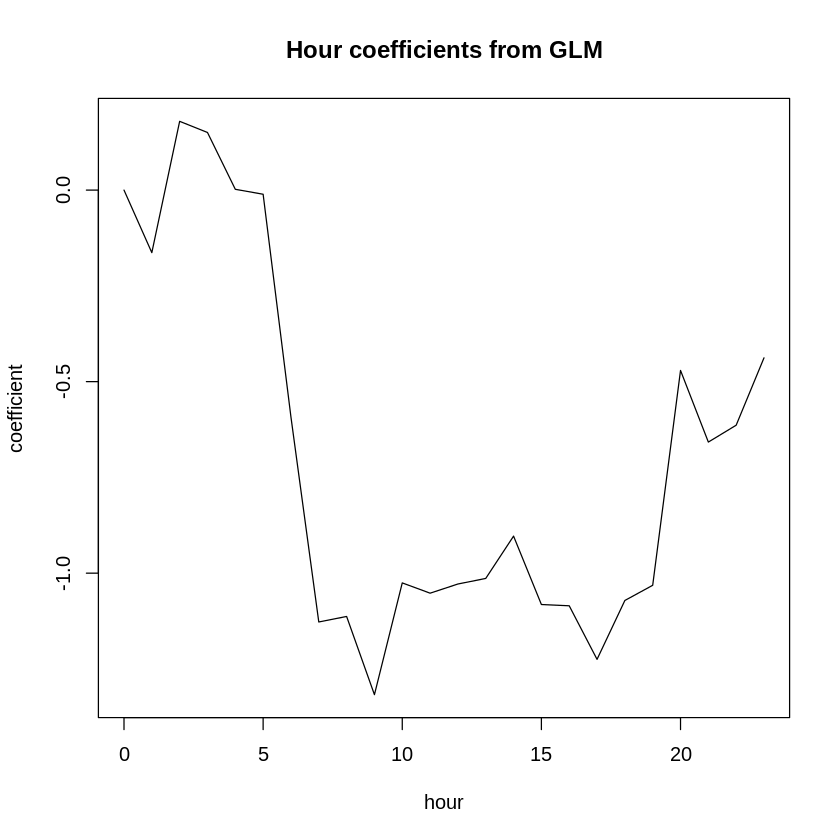

In [7]:
#plot coef by hour

coef_glm <- glmSimple$coefficients

hour_coef <- c(0, coef_glm[grep("^hour_fac", names(coef_glm))])

plot(x = 0:23, y = hour_coef, type = "l", xlab = "hour",
     ylab = "coefficient", main = "Hour coefficients from GLM")


In [8]:
#Predicted probabilities in train and test for glm
predTest <- data.frame(glm = predict(glmSimple, newdata = vicDataTest,
                                     type = "response"))
predTrain <- data.frame(glm = fitted(glmSimple, type = "response"))

## Regularized GLM (Lasso)

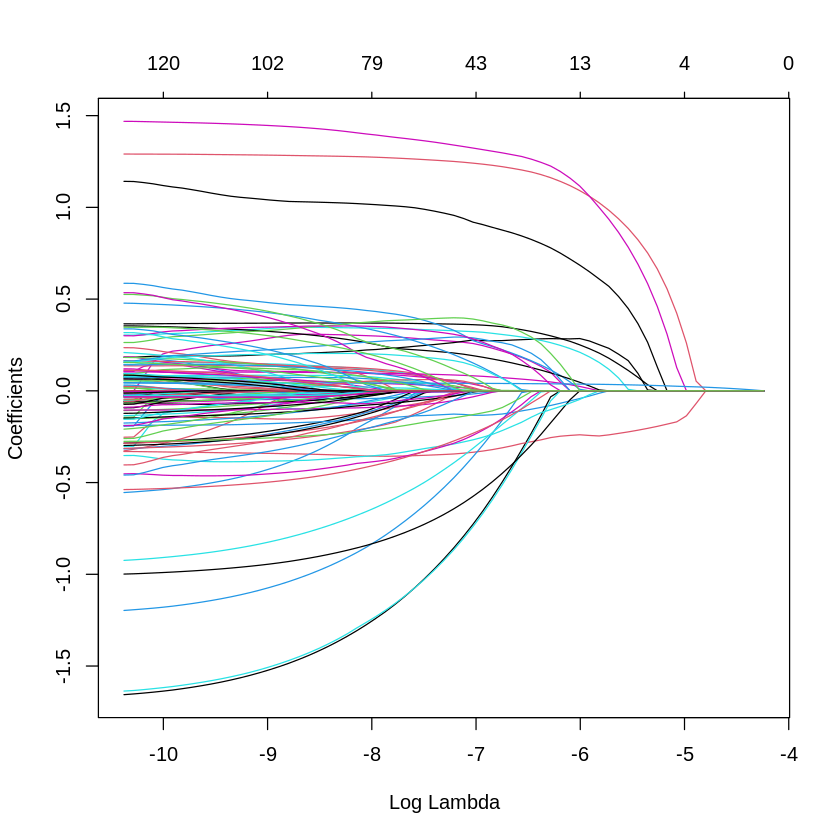

In [9]:
#--------------------------------------------------------------
# Regularised GLM (Lasso)
#--------------------------------------------------------------

library(glmnet)
#Get design Matrix
X <- model.matrix(fatal_cnt ~ ., data = vicDataTrain)[,-1]
Y <- vicDataTrain$fatal_cnt
lasso <- glmnet(x = X, y = Y, alpha = 1, family = "binomial")

#Plot regularisation path
plot(lasso, xvar = "lambda")

In [10]:
#Cross-validation to select lambda
set.seed(2)
cv.lasso <- cv.glmnet(x = X, y = Y, family = "binomial",
                      alpha = 1, nfolds = 10, type.measure = "auc")

#Find index of lambda with the best CV error
index_cv_lamblda <- which(lasso$lambda==cv.lasso$lambda.1se)

#abline(v = log(lasso$lambda[index_cv_lamblda]))

#Predicted probabilities in train and test for lasso at best lambda
newX <- model.matrix(fatal_cnt ~ ., data = vicDataTest)[,-1]
predTest$lasso <- predict(lasso, newx =  newX, type = "response")[, index_cv_lamblda]
predTrain$lasso <- predict(lasso, newx =  X, type = "response")[, index_cv_lamblda]


NULL

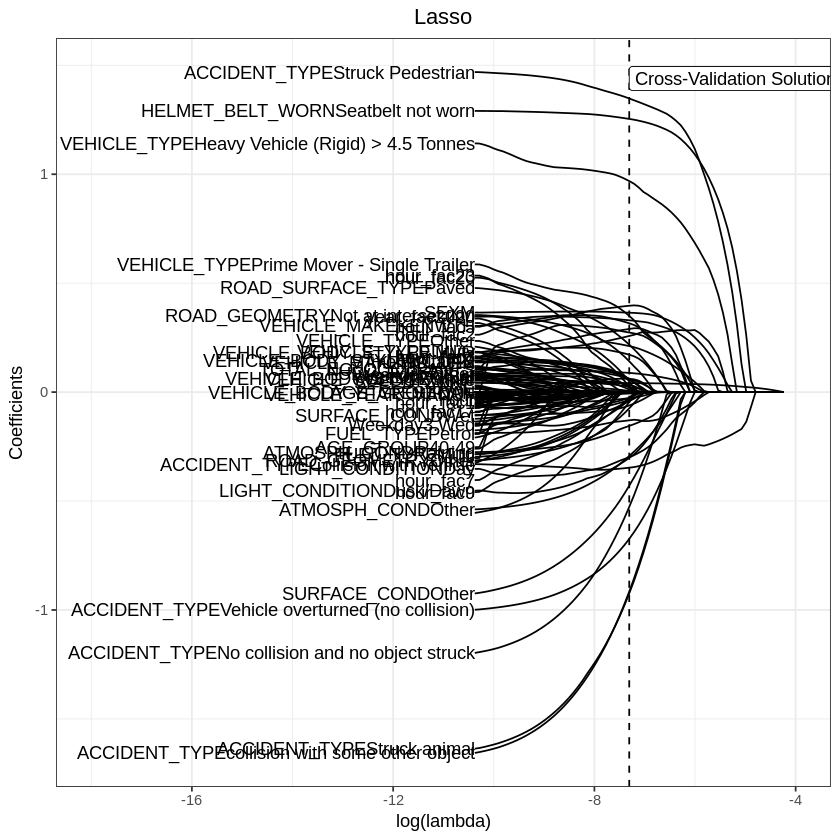

In [11]:
#Optional - Do nice plot of solution path and cross-validation solution

#Function to get data frame with solution path
getSolutionPath <- function(regSol){
  extractSol <- function(regSol, i) tibble(variable = names(regSol$beta[,i]),
                                           beta = regSol$beta[,i],
                                           alpha = regSol$lambda[i])

  map_df(seq(1,length(regSol$lambda)), function(i) extractSol(regSol, i))
}

lassoDF <- getSolutionPath(lasso)


var_in_cv <- lassoDF %>% filter(alpha == cv.lasso$lambda.1se, beta != 0) %>%
  select(variable)
var_in_cv <- var_in_cv$variable

lassoPlot1 <- ggplot(lassoDF, aes(x = log(alpha), y = beta, group = variable)) +
  labs(x = "log(lambda)", y = "Coefficients", title = "Lasso") +
  geom_line() +
  geom_text(data = filter(lassoDF, alpha == last(lassoDF$alpha),
                          variable %in% var_in_cv),
            aes(x = log(alpha), y = beta, label = variable), hjust = 1) +
  xlim(-18, -4) +
  theme_bw() +
  theme(legend.position = "none") +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_colour_manual(values = c("gray50", "black"))
NULL

lassoPlotCV <- lassoPlot1  + geom_vline(xintercept = log(cv.lasso$lambda.1se), linetype = "dashed") +
  annotate(x = log(cv.lasso$lambda.1se), y = max(lassoDF$beta)*0.98, geom = "label",
           label = "Cross-Validation Solution", hjust = 0)


print(lassoPlotCV)


#  Trees, Random Forest, and Boosting

## Trees

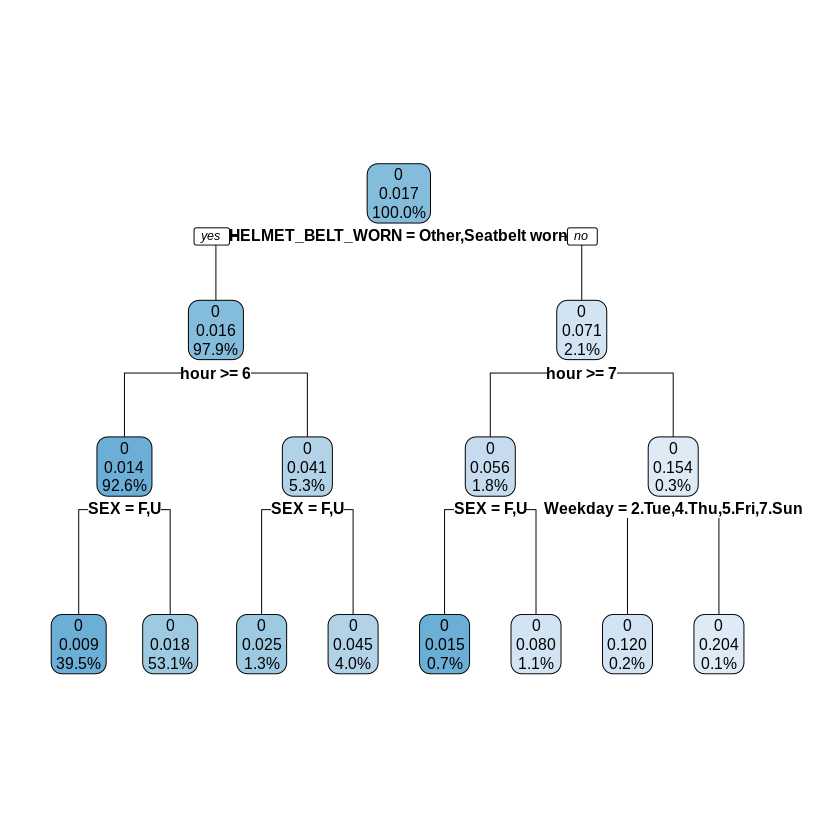

In [12]:
#------------------------------------------------
# Tree
#------------------------------------------------

library(rpart)
library(rpart.plot)

#set control
control <- rpart.control(minsplit = 10, #Minimum number of splits
                         maxdepth = 3,  #Maximum depth of the tree
                         minbucket = 100, #Minimum number of obs in each leaf
                         cp = -1)         #Force every split

#fit the tree
rpartModel <- rpart(fatal_cnt ~ SEX +  AGE + HELMET_BELT_WORN +
                      Weekday + hour, data = vicDataTrain, method = "class",
                    control = control)

#plot the tree
rpart.plot(rpartModel, type = 2, digits = 3)


#Predicted probabilities in train and test for tree
predTest$tree <- predict(rpartModel, newdata = vicDataTest, type = "prob")[,2]
predTrain$tree <- predict(rpartModel, type = "prob")[,2]


## Random Forest

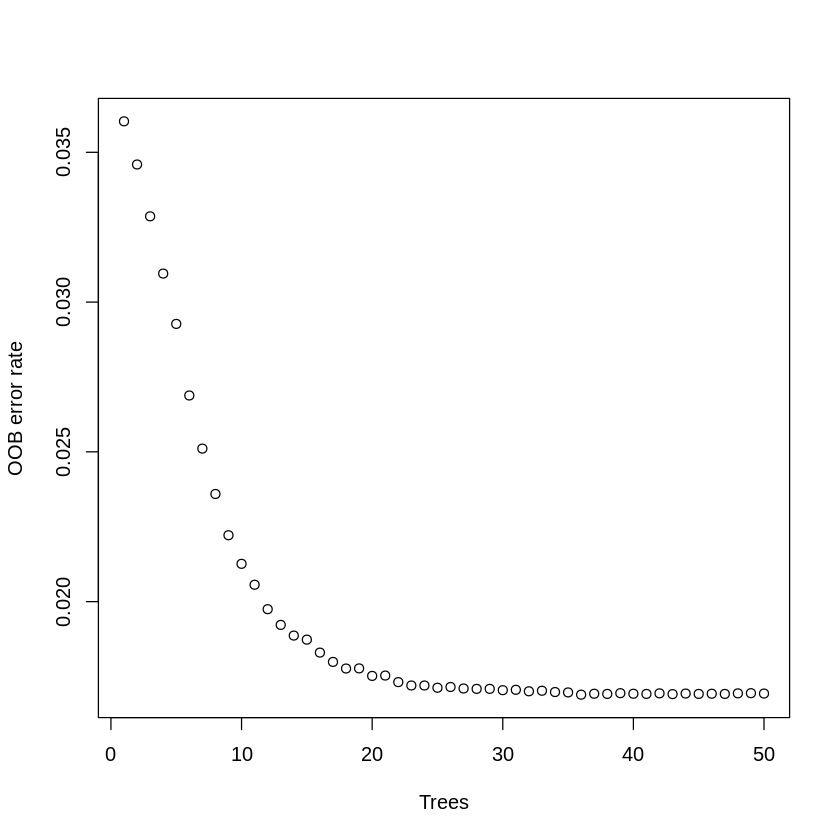

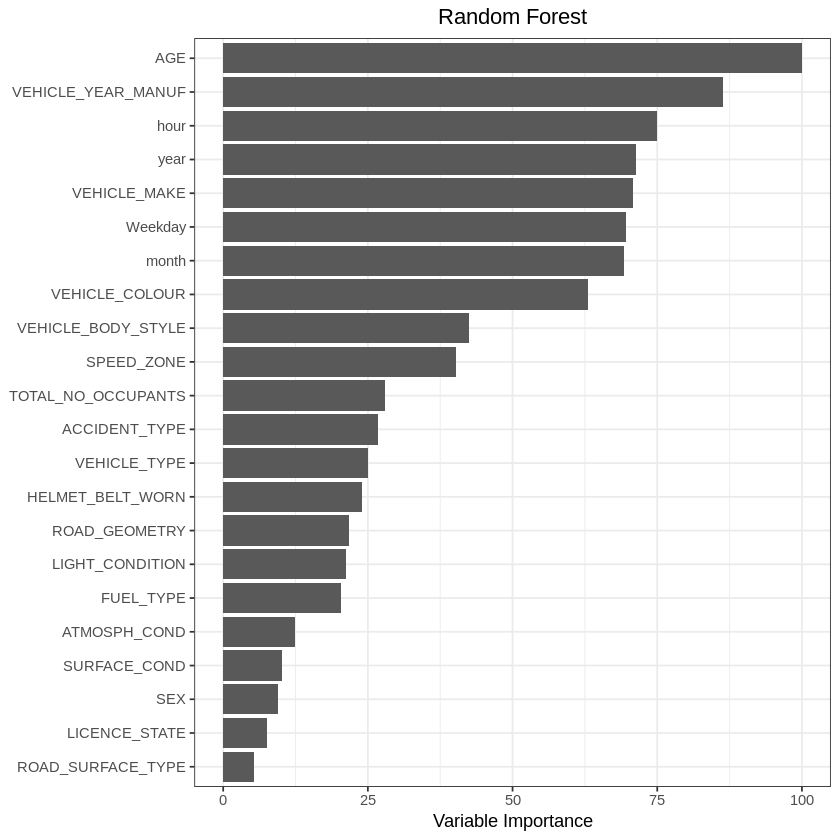

In [13]:
#--------------------------------------------
# Random Forest
#--------------------------------------------

library(randomForest)
set.seed(10)
RFModel <- randomForest(factor(fatal_cnt) ~ .,
                        data=vicDataTrain %>%
                          select(-AGE_GROUP,  #Remove factor version of some variables
                                 -hour_fac,
                                 -month_fac,
                                 -year_fac),
                        importance=TRUE,
                        ntree=50,
                        xtest = vicDataTest %>%
                          select(-AGE_GROUP,  #Remove factor version of some variables
                                 -hour_fac,
                                 -month_fac,
                                 -year_fac,
                                 -fatal_cnt),
                        ytest = factor(vicDataTest$fatal_cnt))

#Plot out of bag error rate
plot(RFModel$err.rate[,1], xlab = "Trees", ylab = "OOB error rate")

# Plot the importantce of the variables
importanceRF <- importance(RFModel)

importanceRF <- as.data.frame(importanceRF) %>%
  mutate(Variable = row.names(importanceRF), VI = MeanDecreaseGini/max(MeanDecreaseGini)*100)


impPlotRF <- ggplot(importanceRF, aes(x = reorder(Variable, VI), y = VI)) +
  geom_bar(stat = "identity") +
  coord_flip() + theme_bw() + theme(plot.title = element_text(hjust = 0.5)) +
  labs(x = NULL, y = "Variable Importance", title = "Random Forest")

print(impPlotRF)


#Predicted probabilities in train and test for RF
predTest$RF <- RFModel$test$votes[, 2]
predTrain$RF <- RFModel$votes[, 2]

## Boosting

Distribution not specified, assuming bernoulli ...


OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.



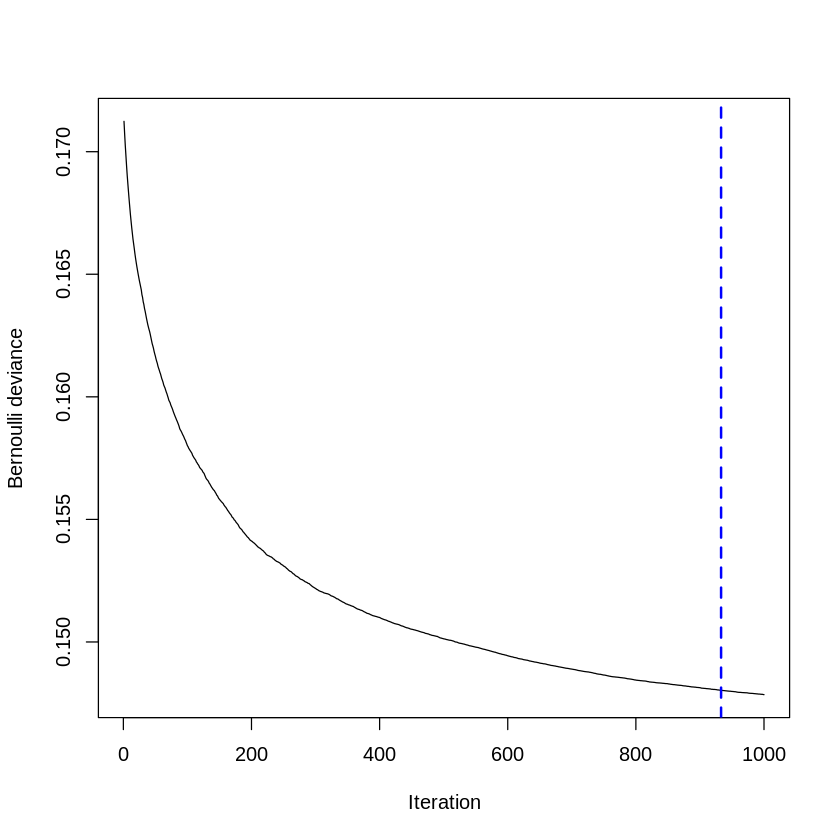

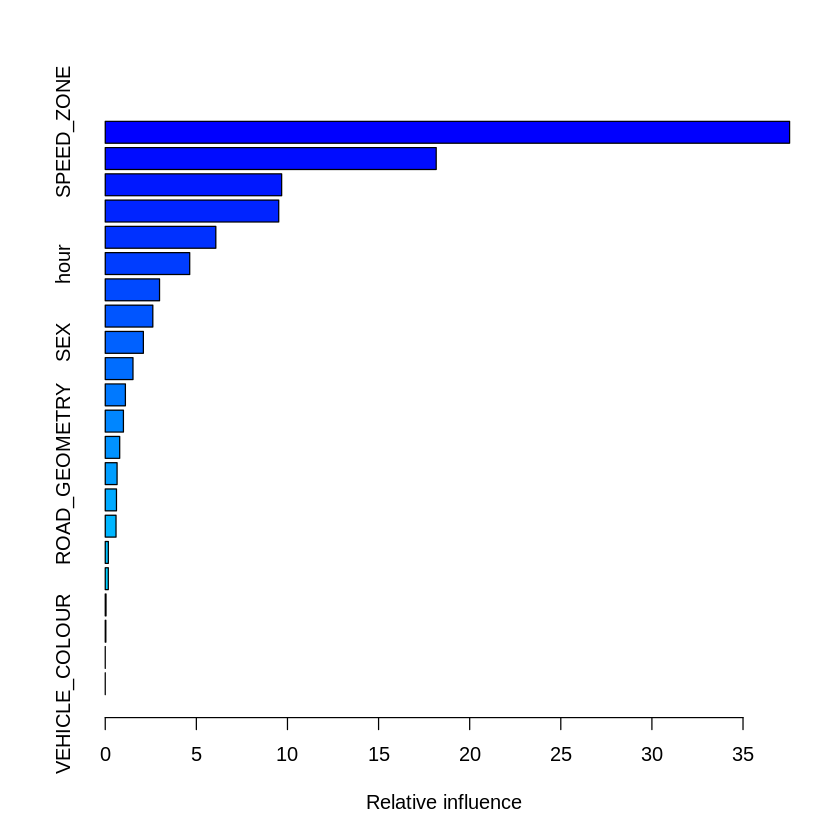

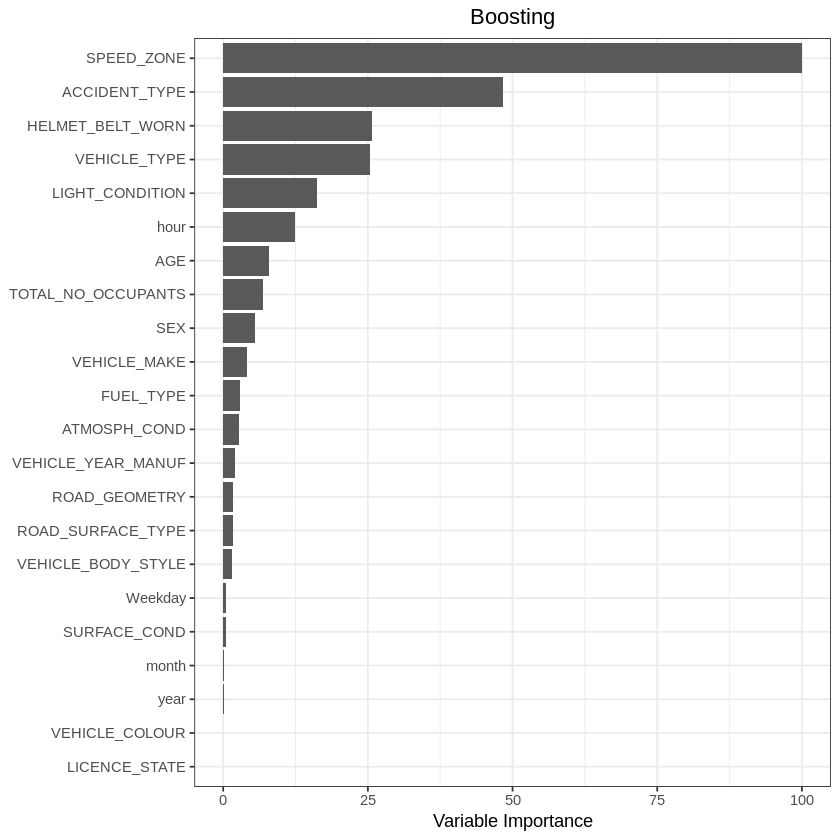

In [14]:
#--------------------------------------------
# Boosting
#--------------------------------------------
library(gbm)
set.seed(10)
boostModel <- gbm(fatal_cnt ~ ., data=vicDataTrain %>%
                    select(-AGE_GROUP,  #Remove factor version of some variables
                           -hour_fac,
                           -month_fac,
                           -year_fac),
                  n.trees = 1000 , interaction.depth = 1, shrinkage = 0.02)


#Plot add of the bag error. And get the best number of trees
bestIter <- gbm.perf(boostModel, method = "OOB")

#Variable importance plot
varImpBoost <- summary(boostModel)

importanceGBM <- data.frame(Variable = varImpBoost$var,
                            VI = varImpBoost$rel.inf/varImpBoost$rel.inf[1]*100)

impPlotGBM <- ggplot(importanceGBM, aes(x = reorder(Variable, VI), y = VI)) +
  geom_bar(stat = "identity") +
  coord_flip() + theme_bw() + theme(plot.title = element_text(hjust = 0.5)) +
  labs(x = NULL, y = "Variable Importance", title = "Boosting")

print(impPlotGBM)

#Predicted probabilities in train and test for GBM

predTest$Boost <- predict(boostModel, newdata = vicDataTest, n.trees = bestIter,
                          type = "response")
predTrain$Boost <- predict(boostModel, newdata = vicDataTrain, n.trees = bestIter,
                           type = "response")


# Model Evaluation

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



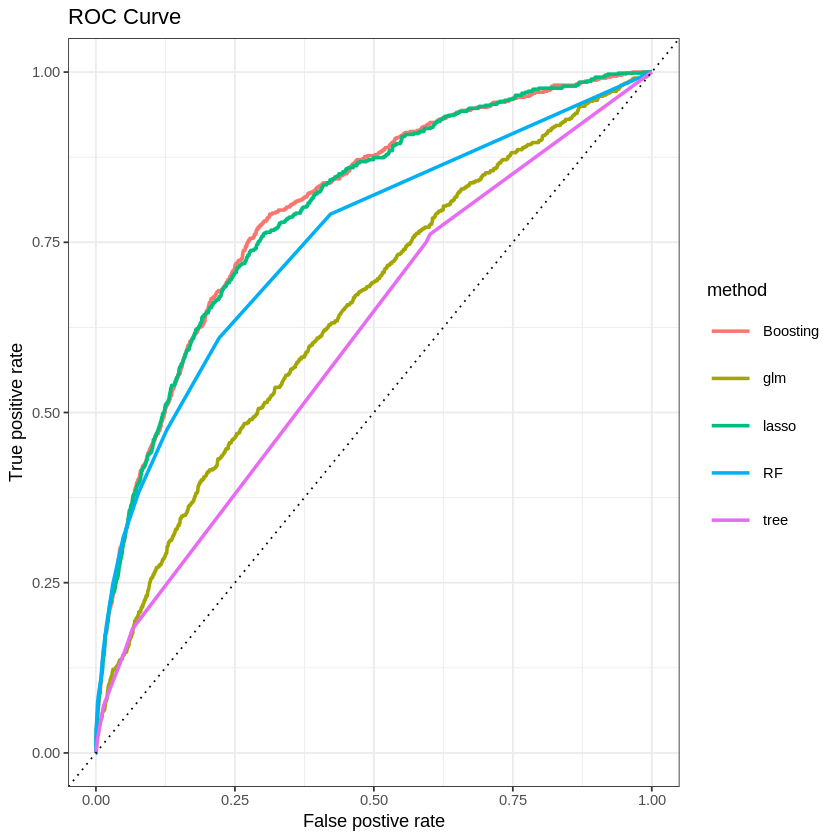

In [15]:
#--------------------------------------------
# Model evaluation
#--------------------------------------------
library(pROC)


ROC_test_glm <- roc(vicDataTest$fatal_cnt, predTest$glm)
ROC_test_lasso <- roc(vicDataTest$fatal_cnt, predTest$lasso)
ROC_test_tree <- roc(vicDataTest$fatal_cnt, predTest$tree)
ROC_test_RF <- roc(vicDataTest$fatal_cnt, predTest$RF)
ROC_test_Boost <- roc(vicDataTest$fatal_cnt, predTest$Boost)

ROC_train_glm <- roc(vicDataTrain$fatal_cnt, predTrain$glm)
ROC_train_lasso <- roc(vicDataTrain$fatal_cnt, predTrain$lasso)
ROC_train_tree <- roc(vicDataTrain$fatal_cnt, predTrain$tree)
ROC_train_RF <- roc(vicDataTrain$fatal_cnt, predTrain$RF)
ROC_Train_Boost <- roc(vicDataTrain$fatal_cnt, predTrain$Boost)


#ROC Curve on testing
get_TP_FP <- function(ROC, method) {
  tibble(TP = ROC[["sensitivities"]],
         FP = 1.0- ROC[["specificities"]],
         method = method) %>% arrange(FP, TP)
}


ROCdata <- bind_rows(get_TP_FP(ROC_test_glm, "glm"),
                     get_TP_FP(ROC_test_lasso, "lasso"),
                     get_TP_FP(ROC_test_tree, "tree"),
                     get_TP_FP(ROC_test_RF, "RF"),
                     get_TP_FP(ROC_test_Boost, "Boosting"))



ROCplotAll <- ggplot(ROCdata) + geom_line(aes(x = FP, y = TP,
                                              group = method, colour = method),
                                          linewidth = 1.0) +
  geom_abline(slope = 1, intercept = 0, linetype = "dotted") +
  theme_bw()  +
  theme(legend.key.size = unit(1, "cm")) +
  labs(x = "False postive rate", y = "True positive rate", title = "ROC Curve")

print(ROCplotAll)

In [16]:
#Get AUC table
get_AUC <- function(ROC_train, ROC_test, method) {
  tibble(method = method,
         train_AUC = as.numeric(ROC_train$auc),
         test_AUC = as.numeric(ROC_test$auc))
}

AUC_Table <- bind_rows(get_AUC(ROC_train_glm, ROC_test_glm, "glm"),
                       get_AUC(ROC_train_lasso, ROC_test_lasso, "lasso"),
                       get_AUC(ROC_train_tree, ROC_test_tree, "tree"),
                       get_AUC(ROC_train_RF, ROC_test_RF, "RF"),
                       get_AUC(ROC_Train_Boost, ROC_test_Boost, "Boosting"))

AUC_Table

method,train_AUC,test_AUC
<chr>,<dbl>,<dbl>
glm,0.6630906,0.6497840
lasso,0.8085793,0.7968887
tree,0.6291516,0.6099287
RF,0.6880410,0.7504817
Boosting,0.8132713,0.8001780
